In [1]:
import json
import sys
sys.path.append("../../")

from didgelab.calc.geo import Geo, geotools

import didgelab.calc.fft
from didgelab.calc.sim.sim import *
from didgelab.calc.fft import *
from didgelab.calc.conv import *
infile = "../../../evolutions/2024-04-08T13-57-06_evolve_arusha/population80.json"
data = json.load(open(infile))
geo = Geo(data[0]["representation"]["geo"])
geo

FileNotFoundError: [Errno 2] No such file or directory: '../../../evolutions/2024-04-08T13-57-06_evolve_arusha/population80.json'

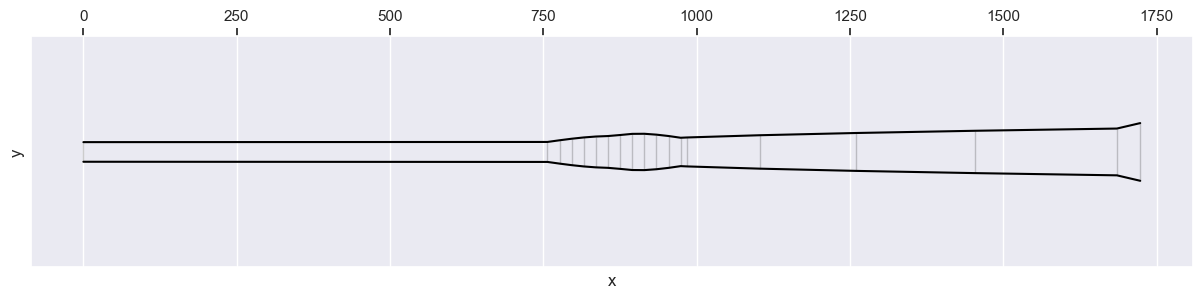

In [ ]:
from didgelab.util.didge_visualizer import vis_didge
vis_didge(geo)

In [ ]:
from didgelab.evo.nuevolution import GeoGenome

base_freq = 440

class MbeyaGemome(GeoGenome):

    def add_param(self, name, minval, maxval):
        self.named_params[name] = {
            "index": len(self.named_params),
            "min": minval,
            "max": maxval
        }

    def get_value(self, name):
        p = self.named_params[name]
        v = self.genome[p["index"]]
        v = v*(p["max"]-p["min"]) + p["min"]
        return v

    def __init__(self, n_bubbles=1, add_bubble_prob=0.7):

        self.named_params = {}

        self.d1=32
        self.add_bubble_prob=add_bubble_prob
        self.n_bubbles=n_bubbles

        # straight part
        self.add_param("l_gerade", 500, 1500)
        self.add_param("d_gerade", 0.9, 1.2)

        # opening part
        self.add_param("n_opening_segments", 0, 8)
        self.add_param("opening_factor_x", -2, 2)
        self.add_param("opening_factor_y", -2, 2)
        self.add_param("opening_length", 700, 1000)

        # bell
        self.add_param("d_pre_bell", 40, 50)
        self.add_param("l_bell", 20, 50)
        self.add_param("bellsize", 5, 30)

        # bubble
        for i in range(self.n_bubbles):
            self.add_param(f"add_bubble_{i}", 0, 1)
            self.add_param(f"bubble_height_{i}", -0.5, 1)
            self.add_param(f"bubble_pos_{i}", 0, 1)
            self.add_param(f"bubble_width_{i}", 150, 300)

        GeoGenome.__init__(self, n_genes = len(self.named_params))

    def make_bubble(self, shape, pos, width, height):

        n_segments=11

        i=self.get_index(shape, pos-0.5*width)

        bubbleshape=shape[0:i]

        x=pos-0.5*width
        y=Geo(geo=shape).diameter_at_x(x)

        if shape[i-1][0]<x:
            bubbleshape.append([x,y])

        for j in range(1, n_segments):
            x=pos-0.5*width + j*width/n_segments

            # get diameter at x
            y=Geo(geo=shape).diameter_at_x(x)
            factor=1+math.sin(j*math.pi/(n_segments))*height
            y*=factor

            bubbleshape.append([x,y])

        x=pos+0.5*width
        y=Geo(geo=shape).diameter_at_x(x)
        bubbleshape.append([x,y])

        while shape[i][0]<=bubbleshape[-1][0]+1:
            i+=1
        
        bubbleshape.extend(shape[i:])

        return bubbleshape

    # return last index that is smaller than x
    def get_index(self, shape, x):
        for i in range(len(shape)):
            if shape[i][0]>x:
                return i
        return len(shape)-1

    def genome2geo(self):
        shape=[[0, self.d1]]

        # straight part
        p=[self.get_value("l_gerade"), shape[-1][1]*self.get_value("d_gerade")]
        shape.append(p)

        # opening part
        n_seg=self.get_value("n_opening_segments")
        seg_x=[]
        seg_y=[]
        for i in range(int(n_seg)):
            x=pow(i+1, self.get_value("opening_factor_x"))
            y=pow(i+1, self.get_value("opening_factor_y"))
            seg_x.append(x)
            seg_y.append(y)

        def normalize(arr):
            m=sum(arr)
            return [x/m for x in arr]

        seg_x=normalize(seg_x)
        seg_y=normalize(seg_y)
        seg_x=[x*self.get_value("opening_length") for x in seg_x]
        seg_y=[y*self.get_value("d_pre_bell") for y in seg_y]

        start_x=shape[-1][0]
        start_y=shape[-1][1]
        for i in range(int(n_seg)):
            x=sum(seg_x[0:i+1]) + start_x
            y=sum(seg_y[0:i+1]) + start_y
            shape.append([x,y])

        p=[shape[-1][0] + self.get_value("l_bell"), shape[-1][1]+self.get_value("bellsize")]
        shape.append(p)

        # add bubble
        for i in range(self.n_bubbles):
            if self.get_value(f"add_bubble_{i}")<self.add_bubble_prob:
                pos=shape[-1][0]*self.get_value(f"bubble_pos_{i}")
                width=self.get_value(f"bubble_width_{i}")
                height=self.get_value(f"bubble_height_{i}")
                if pos-width/2<-10:
                    pos=width/2 + 10
                if pos+width/2+10>shape[-1][0]:
                    pos=shape[-1][0]-width/2 - 10
                shape=self.make_bubble(shape, pos, width, height)

        geo=Geo(shape)
        geo=geotools.fix_zero_length_segments(geo)
        return geo

# a loss that deviates 
def single_note_loss(note, peaks, i_note=0, filter_rel_imp=0.1):
    peaks=peaks[peaks.rel_imp>filter_rel_imp]
    if len(peaks)<=i_note:
        return 1000000
    f_target=note_to_freq(note, base_freq=base_freq)
    f_fundamental=peaks.iloc[i_note]["freq"]
    return np.sqrt(abs(math.log(f_target, 2)-math.log(f_fundamental, 2)))

geos = []
for i in range(10):
    genome = MbeyaGemome()
    genome.randomize_genome()
    geos.append(genome.genome2geo())

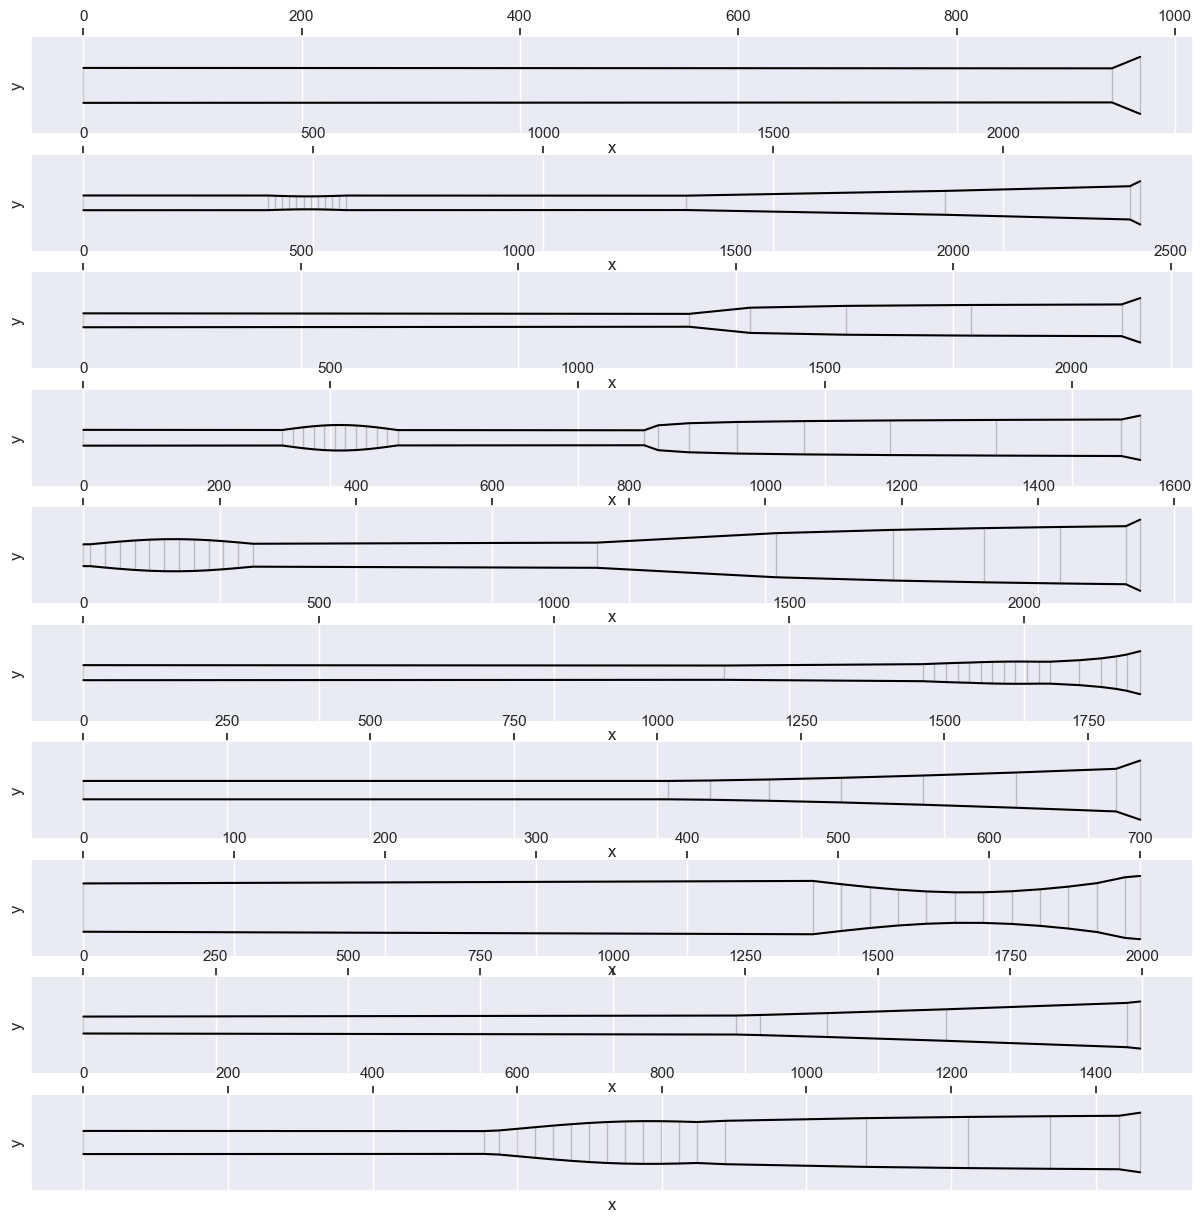

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,15))
for i in range(len(geos)):
    plt.subplot(len(geos), 1, i+1)
    vis_didge(geos[i])


In [ ]:
from didgelab.calc.conv import note_to_freq

print(note_to_freq(-30, base_freq=base_freq))
print(note_to_freq(-31, base_freq=base_freq))
print(note_to_freq(-32, base_freq=base_freq))

77.78174593052023
73.41619197935188
69.29565774421802


In [ ]:
print(freq_to_note_and_cent(68.395682, base_freq=base_freq))

NameError: name 'freq_to_note_and_cent' is not defined

In [ ]:
infile = "../../../evolutions/2024-04-08T13-57-06_evolve_arusha/population80.json"
data = json.load(open(infile))
geo = Geo(data[0]["representation"]["geo"])

freqs = get_log_simulation_frequencies(1, 1000, 5)
segments = create_segments(geo)
impedances = compute_impedance(segments, freqs)
notes = get_notes(freqs, impedances, base_freq=base_freq).to_string()
print(notes)

  note_name  cent_diff  note_nr        freq  impedance   rel_imp
0        D1  17.631656      -31   72.672283  25.936034  1.000000
1        D2  37.631656      -19  143.675142   9.525911  0.367285
2        C3  32.631656       -9  256.740426   2.313601  0.089204
3        F3  37.631656       -4  341.719003   5.531285  0.213266
4       A#4  47.631656        1  453.512970   0.526493  0.020300
5       C#4  32.631656        4  544.014012   3.285461  0.126676
6       F#4 -17.368344        9  747.450036   1.526398  0.058852
7        A5 -47.368344       12  904.410125   0.897854  0.034618
8        B5   7.631656       14  983.421896   0.843188  0.032510


In [ ]:
def generation_ended(i_generation, population):
    genome = population[0]
    losses = [f"{key}: {value}" for key, value in genome.loss.items()]
    msg = "\n".join(losses)
    
    geo = genome.genome2geo()
    freqs = get_log_simulation_frequencies(1, 1000, 5)
    segments = create_segments(geo)
    impedances = compute_impedance(segments, freqs)
    notes = get_notes(freqs, impedances, base_freq=base_freq).to_string()
    msg += "\n" + notes


In [ ]:
infile = "../../../evolutions/2024-04-08T13-57-06_evolve_arusha/population80.json"
data = json.load(open(infile))
geo = Geo(data[0]["representation"]["geo"])
